Notebook to import data from Google Trends given CSV files and scale them and perform ANOVA (and eventually Tukey HSD) analysis. 

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import scipy
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

Here, I'm going to use pandas to import data from all CSVs that i tell it to import data from into a pandas dataframe

In [2]:
files = ["EuroHis", "ComputerScience", "Chemistry", "Biology", "Physics", "Macro", "MusicTheory", "Statistics", "USHis", "Psych"]
data = []
scaler = preprocessing.MinMaxScaler()
for name in files: 
    i = files.index(name)
    full_rel_path = "raw-datasets/" + name + ".csv"
    data.append(pd.read_csv(full_rel_path, sep=",", header=None, skiprows=3)) # First 3 rows have headers that I don't want
    data[i] = data[i].drop(data[i].columns[0], axis=1)
    data[i] = data[i].replace('<1', '0.1')
    data[i].apply(pd.to_numeric)
    data[i].columns = ['AP ' + name + ' interest', name + ' interest']
    data[i]['AP ' + name + ' interest (scaled)'] = scaler.fit_transform(data[i]['AP ' + name + ' interest'].values.reshape(-1,1))
    data[i][name + ' interest (scaled)'] = scaler.fit_transform(data[i][name + ' interest'].values.reshape(-1,1))
    data[i] = data[i].drop('AP ' + name + ' interest', 1)
    data[i] = data[i].drop(name + ' interest', 1)
    data[i].to_csv('scaled-datasets/' + name + '.csv')
    dataset = data[i].to_numpy()

The above exporting of the scaled dataset is occuring just to backup data in case of failure

In [3]:
dev_stats = []
for df in data: 
    ap_diff = []
    field_diff = []
    ap_mean = df[df.columns[0]].mean()
    field_mean = df[df.columns[1]].mean()
    for index, row in df.iterrows(): 
        ap_interest = row[df.columns[0]]
        field_interest = row[df.columns[1]]
        ap_diff.append((ap_mean - ap_interest) ** 2) # must be squared because the negative and positive versions cause issues. 
        field_diff.append((field_mean - field_interest)**2)
    dev_stats.append(pd.DataFrame(list(zip(ap_diff, field_diff)),columns =['AP Interest DEV Stat', 'Field DEV Stat']))

The above cell takes all of the data processed, calculated the DEV stat, and adds it to the dataframe

In [4]:
ap_input = []
field_input = []
for df in dev_stats:
    ap_input.append(np.array(df[df.columns[0]]))
    field_input.append(np.array(df[df.columns[1]]))
print(scipy.stats.f_oneway(ap_input[0], ap_input[1], ap_input[2], ap_input[3], ap_input[4], ap_input[5], ap_input[6], ap_input[7], ap_input[8]))
print(scipy.stats.f_oneway(field_input[0], field_input[1], field_input[2], field_input[3], field_input[4], field_input[5], field_input[6], field_input[7], field_input[8]))

F_onewayResult(statistic=14.730607647241548, pvalue=5.130378436957413e-21)
F_onewayResult(statistic=3.593960576581632, pvalue=0.000377721919440899)


In [5]:
print(type(ap_input[0]))

<class 'numpy.ndarray'>


This above cell is able to take the data and run ANOVA

train log loss:
training   (min:    0.532, max:    5.150, cur:    0.532)


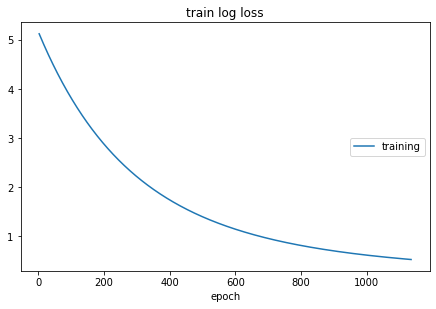

KeyboardInterrupt: 

In [7]:
import torch
import os
import datetime
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = {
    "batch_size": 4, 
    "input_size": 3,
    "hidden_size": 100, 
    "hidden1_size": 40,
    "output_size": 3,
    "epochs": 1000000,
    "log_rate": 1000
}
N, i, h, h1, o = config["batch_size"], config["input_size"], config["hidden_size"], config["hidden1_size"], config["output_size"]
log_rate = config["log_rate"]
# x = torch.randn(N, i)
# y = torch.randn(N, o)
x = torch.tensor(np.array([[2,3,4], [3,5,6], [6,7,9], [7,3.4,2]])).to(torch.float)
y = torch.tensor(np.random.rand(N,o)).to(torch.float)
liveloss = PlotLosses()
model = torch.nn.Sequential(
    torch.nn.Linear(i, h),
    torch.nn.Tanh(),
    torch.nn.Linear(h, h1),
    torch.nn.Tanh(),
    torch.nn.Linear(h1, o),
).to(device)
loss_fn = torch.nn.MSELoss(reduction='sum')
print(datetime.datetime.now())
learning_rate = 1e-5
model.train()
for t in range(config["epochs"]):
    logs = {}
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'loss': loss,
        }, "models/interim_model")
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    logs['train log loss'] = loss.item()
    liveloss.update(logs)
    liveloss.draw()
torch.save(model.state_dict(), "models/interim_model")
os.rename("models/interim_model", "models/final_model")
print(datetime.datetime.now())

## 

In [ ]:
import numpy as np

# Some constants
epochs = 1000000
learning_rate = 1e-6
batch_size = 2
log_rate = epochs / 10
i_1, h_1, o_1 = 3, 100, 3

x = np.random.rand(N, i_1)
y = np.random.rand(N, o_1)

# weight the layers
w1 = np.random.randn(i_1, h_1)
w2 = np.random.randn(h_1, o_1) 

for t in range(epochs):
    h = x.dot(w1)
    h_relu = np.tanh(h) #relu this bad boi
    y_pred = h_relu.dot(w2)
    loss = np.square(y_pred - y).sum()
    if t % log_rate == 0 or t == epochs - 1:
        print("Epoch: " , t, "Loss is: ", loss)
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    